### Instructions

**Part A)**

0) We ask you to create a folder for you project, in which you will be working on the project. You will be asked to send us this project that we can look at your progress and browse through your work. Please follow the instructions in the seminar or a documentation of julia about the activation of an environment and use it for your project. (It can be found also here: https://pkgdocs.julialang.org/v1/environments/ even it is from prompt/terminal, in a notebook use `Pkg.activate(".")`) 
* In your project, you will be adding packages, using them, you can create a script files as well and load them (with helper functions if needed.)


1) Use package `MarketData`, `Quandl`, or different one, if needed go to their github pages and `docs`, then **download data for an asset** of your choice.
2) Use plot to look at the data, do some summary statistics, `Statistics`, `DataFrames`, `StatsPlots` packages
3) Use GARCH to **model** asset data and **forecast**.
3) **Plot** forecasts.
    
This part is for you to get you familiar with julia, its syntax, and pacakges.

---

### 0.

#### Environment activation

In [1]:
#Activate the environment
using Pkg
Pkg.activate(".")

  Activating project at `d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1`


#### Loading required packages

In [2]:
#Load required packages
using MarketData
using Statistics
using DataFrames
using StatsPlots
using GARCH

┌ Info: Precompiling GARCH [4d2f22df-77d7-5622-8d7f-1db4ec2bcc3a]
└ @ Base loading.jl:1664


### 1.

We have chosen the McDonald's stock price as the variable of interest. We will download it from Yahoo Finance. We acquire only 10 years worth of data (January 2012 - December 2021) since ancient history may not have relevance for the present, in fact, it may adversely affect the forecasts.

In [4]:
#Download data for McDonald's stock from Yahoo (37.6s)
t1 = DateTime(2012, 1, 1) #Starting period
t2 = DateTime(2022, 1, 1) #Ending period
MCD = yahoo("MCD", YahooOpt(period1 = t1, period2 = t2));

We are interested only in the adjusted close price so we will store it in a variable. We also calculate the log-returns since we do not expect the price to be stationary.

In [5]:
#Store only the Adjusted Close price
MCD_adj_close = values(MCD[:AdjClose])

#Calculate log-returns
MCD_log_ret = diff(log.(MCD_adj_close));

### 2.

In this section we provide some fundamental summary statistics.

In [7]:
#Define function for summary statistics
n(x) = size(x)[1] #Define a function calculating the number of observations
quantile_5(x) = quantile(x, 0.05) #Define a function calculating the 5th percentile
quantile_25(x) = quantile(x, 0.25) #Define a function calculating the 25th percentile
quantile_75(x) = quantile(x, 0.75) #Define a function calculating the 75th percentile
quantile_95(x) = quantile(x, 0.95) #Define a function calculating the 95th percentile
skewness(x) = sum((x .- mean(x)) .^ 3) / (size(x)[1] * std(x) ^ 3) #Define a function calculating skewness
kurtosis(x) = sum((x .- mean(x)) .^ 4) / (size(x)[1] * std(x) ^ 4) #Define a function calculating skewness 
sum_stats = [n, mean, std, quantile_5, quantile_25, median, quantile_75, quantile_95, skewness, kurtosis] #Store the functions caclulating summary statistics into a vector for looping
str_info = ["Number of observations: ", "Mean: ", "Standard deviation: ", "5th percentile: ", "25th percentile: ", "Median: ", "75th percentile: ", "95th percentile: ", "Skewness: ", "Kurtosis: "] #Define strings to be printed

#Print summary statistics for raw price
println("Raw price")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_adj_close), digits = 2)))
end

#Print summary statistics for log-returns
println("")
println("Log-returns")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_log_ret), digits = 2)))
end


Raw price
Number of observations: 2517.0
Mean: 129.33
Standard deviation: 54.89
5th percentile: 68.85
25th percentile: 77.23
Median: 108.6
75th percentile: 175.74
95th percentile: 228.27
Skewness: 0.54
Kurtosis: 1.97

Log-returns
Number of observations: 2516.0
Mean: 0.0
Standard deviation: 0.01
5th percentile: -0.02
25th percentile: -0.0
Median: 0.0
75th percentile: 0.01
95th percentile: 0.02
Skewness: -0.19
Kurtosis: 40.53


The summary statistics suggest that the price is slightly positively skewed and its kurtosis is lower than the kurtosis of normal distribution. On the other hand, the returns appear to be more symmetric (even though slightly negatively skewed) and with very heavy tails (high kurtosis). The average return is roughly zero (measured by both the mean and the median) so in general the distribution of the returns does not deviate from our expectations.

We can also plot the time series of the prices as well as returns. We can see that there is an obvious trend in price and as is common for asset prices, the time series is far from stationary.

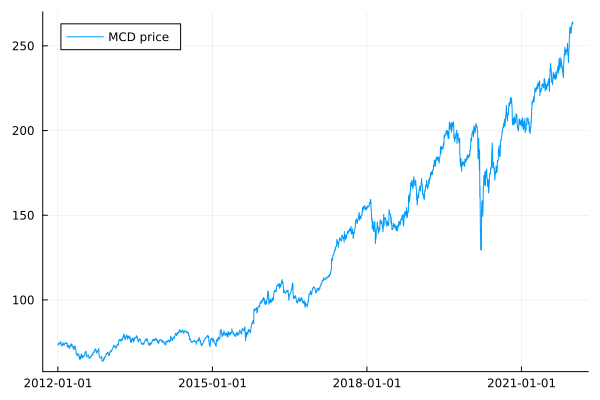

In [14]:
#Plotting the time series of price
plot(MCD[:AdjClose], labels = "MCD price", legend = :topleft)

On the other hand, the returns appear to be mean-stationary. However, we can observe some large variance clusters.

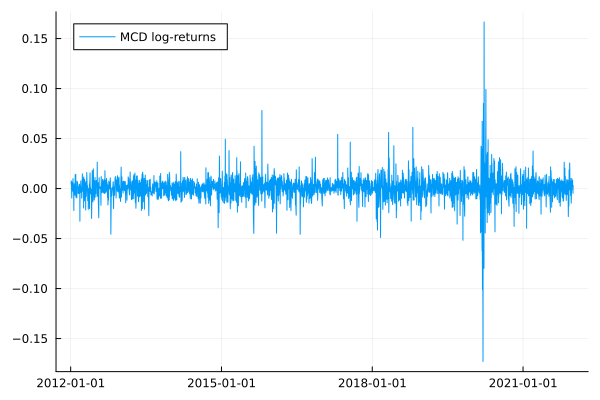

In [15]:
#Plotting the time series of log-returns
plot(TimeArray(timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns", legend = :topleft)

The inspection of histogram may give an insight into the shape of a distribution of a variable. As we can see, the histogram of MCD price below indicates that the series is positively skewed. This corresponds to the positive skewness calculated in the summary statistics.

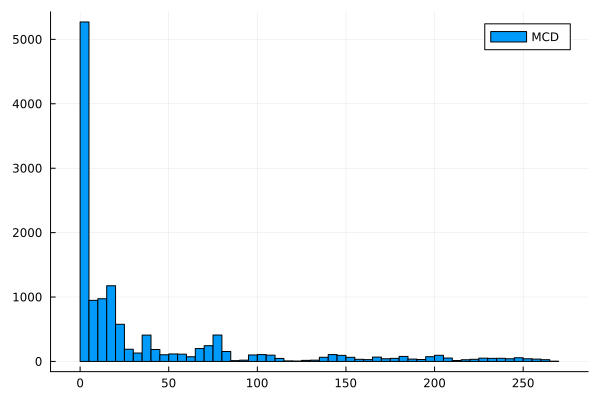

In [9]:
#Plot histogram of price
histogram(MCD[:AdjClose], labels = "MCD price")

On the other hand, the returns appear to be symmetric and with very heavy tails.

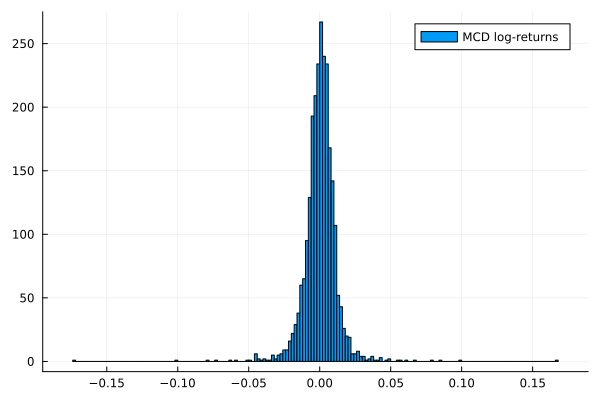

In [16]:
#Plot histogram of log-returns
histogram(TimeArray(timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns")

#### 3. 

In this section we estimate a GARCH model using the returns on the MCD's asset. We can see that all the estimated coefficients are statistically significant.

In [22]:
#Estimating GARCH
MCD_ret = diff(log.(MCD_adj_close))
MCD_fit = garchFit(MCD_ret)

Fitted garch model 
 * Coefficient(s):    ω              α              β              
                      2.0265e-06     0.055052       0.93833        
 * Log Likelihood: 36587
 * Converged: true
 * Solver status: XTOL_REACHED

 * Standardised Residuals Tests:
                             Statistic      p-Value        
   Jarque-Bera Test     χ²   4122           0              

 * Error Analysis:
          Estimate       Std.Error      t value        Pr(>|t|)       
   ω      2.0265e-06     2.625e-07      7.7201         1.1546e-14     
   α      0.055052       0.0034768      15.834         0              
   β      0.93833        0.0037808      248.18         0              


#### 4.

In this section we make forecasts using the estimated model and plot them.

In [11]:
#Make forecasts
MCD_forecasts = predict(MCD_fit)

0.015421594285213818

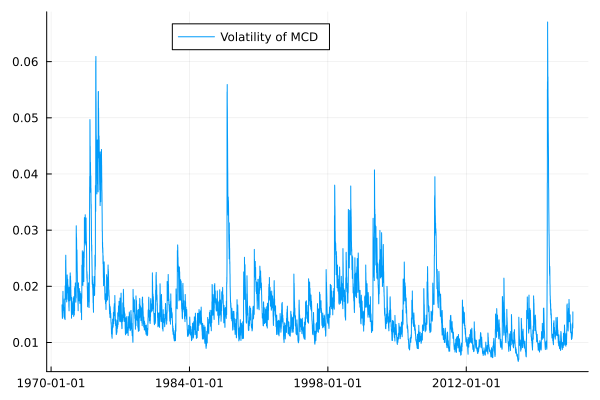

In [23]:
#Plot the fitted values
MCD_fit_timearray = TimeArray(timestamp(MCD[2:end,]), MCD_fit.sigma)
plot(MCD_fit_timearray, labels = "Volatility of MCD", legend = :top)

In [13]:
#making 1-step-ahead predictions on rolling window
MCD_ret = diff(log.(MCD_adj_close))
MCD_ret_len = length(MCD_ret)
sigma_preds = zeros(0)

for i in (MCD_ret_len/2):MCD_ret_len-1
#for i in 7000:7010
    # win_start = Int((i-MCD_ret_len/2)+1) #1:26 - this is more readable version of code but takes longer on 100 obs
    # win_end = Int(i)
    # MCD_fit = garchFit(MCD_ret[win_start:win_end])

    MCD_fit = garchFit(MCD_ret[Int((i-MCD_ret_len/2)+1):Int(i)]) #1:16


    append!( sigma_preds, predict(MCD_fit) )
end

In [14]:
sigma_preds

11-element Vector{Float64}:
 0.025893732854021058
 0.025119594833962366
 0.024559181615748937
 0.023822338954801705
 0.02314543380434222
 0.022890387318158817
 0.02314200368921003
 0.022486923520181404
 0.021903263404385993
 0.021343495726303348
 0.021710534627808913

In [53]:
MCD_fit_timearray[Int(length(MCD_fit_timearray)/2)+1:end]
MCD_preds_timearray = TimeArray(timestamp(MCD_fit_timearray[Int(length(MCD_fit_timearray)/2)+1:end]), sigma_preds)


6518×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1996-11-21 to 2022-10-14
│            │ A      │
├────────────┼────────┤
│ 1996-11-21 │ 0.0124 │
│ 1996-11-22 │ 0.0121 │
│ 1996-11-25 │ 0.0121 │
│ 1996-11-26 │ 0.0119 │
│ 1996-11-27 │ 0.0119 │
│ 1996-11-29 │ 0.0123 │
│ 1996-12-02 │ 0.0124 │
│ 1996-12-03 │ 0.0124 │
│ ⋮          │ ⋮      │
│ 2022-10-06 │ 0.0132 │
│ 2022-10-07 │ 0.0135 │
│ 2022-10-10 │ 0.0133 │
│ 2022-10-11 │ 0.0131 │
│ 2022-10-12 │ 0.0129 │
│ 2022-10-13 │ 0.0126 │
│ 2022-10-14 │ 0.0154 │

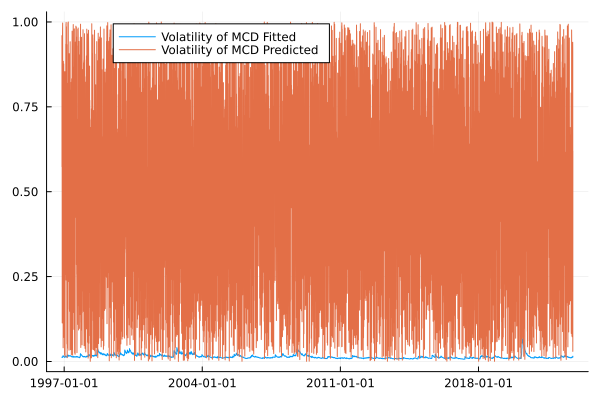

In [58]:
MCD_preds_timearray = TimeArray(timestamp(MCD_fit_timearray[Int(length(MCD_fit_timearray)/2)+1:end]), sigma_preds)
fits_preds_plot = merge(MCD_fit_timearray[Int(length(MCD_fit_timearray)/2)+1:end], MCD_preds_timearray)
plot(mergedts, label = ["Volatility of MCD Fitted" "Volatility of MCD Predicted"], legend = :top)